# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2024. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
# Imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from lifelines import KaplanMeierFitter

In [2]:
# Define constants
ROUNDING_DIGITS = 2
STARTING_DAY = 580

We need data of single and multiple treatments. For that we used the data of the first study of ['Robust Mouse Rejuvenation' (RMR)](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1). Unfortunately we did not get access to their data set, but their evaluation plots are available [online](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1/study-updates/november-5th-2023-cem49). So lets have a look at it.

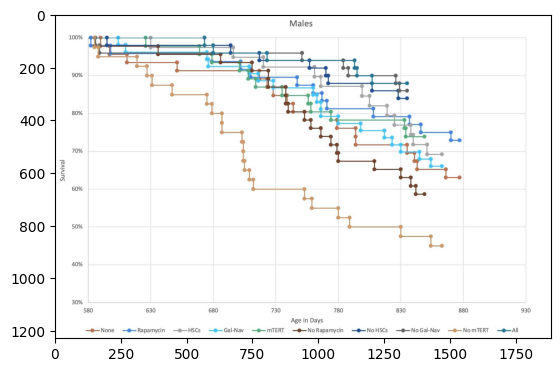

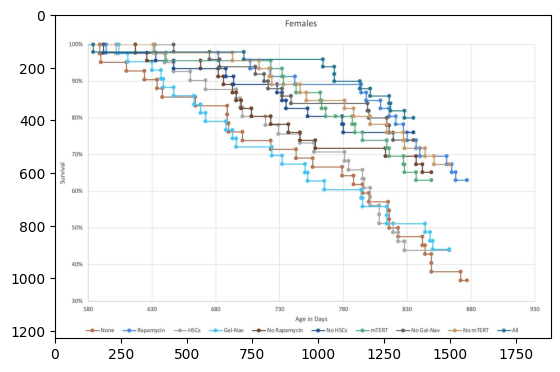

In [3]:
raw_plot_image_male = cv2.imread('../dat/img/23_12_RMR_Males.jpg')
plt.imshow(raw_plot_image_male)
plt.show()
raw_plot_image_female = cv2.imread('../dat/img/23_12_RMR_Females.jpg')
plt.imshow(raw_plot_image_female)
plt.show()

We are lucky that there are not that many data points in each plot. So that is why we took the fastest option for us and collected the data points manually. For that we used [plotdigitilizer](https://plotdigitizer.com/).

In [4]:
def loadCSV(path):
    df = pd.read_csv(
        path,
        skiprows=0,
        sep=",",
        engine="python",
        decimal=".",
        dtype={'x': 'float64', 'y': 'float64'}
        )
    return df

female_df = loadCSV("../dat/RMR_data/female_All.csv")

female_df

,x,y
0,580.000000,1.000000
1,583.372824,1.000971
2,583.994939,0.980644
3,701.648545,0.981767
4,702.152320,0.962346
5,764.073169,0.961043
6,764.156189,0.940411
7,773.023878,0.922168
8,773.294536,0.900950
9,773.372092,0.942677


First you can see that each data point provides a lot of floating point numbers. That comes from the manual elicitation of the data points.
 
That is why we decided to round the points to **2 digits** in our analysis to denoise our data. Furthermore we added the starting point **(580, 1)** by hand. We did this because the study started their interventions with the mice after **18 months**. (See [RMR](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1))

In [5]:
def roundNumbers(df):
    df = df.apply(lambda x:round(x, ROUNDING_DIGITS))
    return df

female_df = roundNumbers(female_df)

female_df

,x,y
0,580.00,1.00
1,583.37,1.00
2,583.99,0.98
3,701.65,0.98
4,702.15,0.96
5,764.07,0.96
6,764.16,0.94
7,773.02,0.92
8,773.29,0.90
9,773.37,0.94


## Sanity Check
We want to see if our data points are representing the data of the figures. We will check this with a plot.

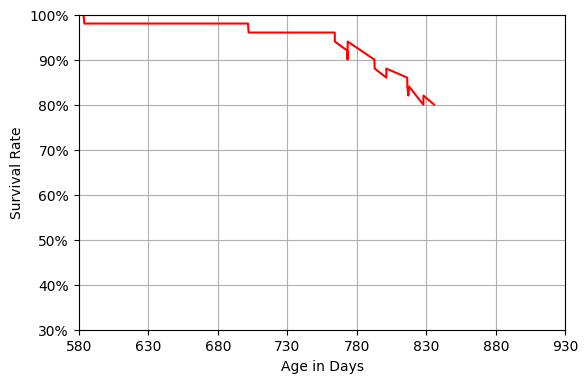

In [6]:
fig, ax = plt.subplots()

# We want to save the image as a .jpg file because the input file is also given as .jpg

# Desired pixel dimensions
width_px = 1884
height_px = 1228
dpi = 300

# Calculate the size in inches. That is necessary because we have to set the figure in inches
width_in = width_px / dpi
height_in = height_px / dpi

x_data = female_df['x']
y_data = female_df['y']
ax.plot(x_data, y_data, color='red')

fig.set_size_inches(width_in, height_in)

ax.set_xlim(580, 930)
ax.set_ylim(0.3, 1)
ax.set_xticks(np.arange(580, 931, 50))
ax.set_yticks(np.arange(0.3, 1.01, 0.1))
ax.grid(True)
ax.set_xlabel('Age in Days')
ax.set_ylabel('Survival Rate')
#ax.legend(['First line', 'Second line'])

def to_percent(y, position):
    return f"{100 * y:.0f}%"

# Create a formatter and apply it to the y-axis
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

fig.savefig("../dat/img/2401_sanity_check.jpg", dpi=dpi)

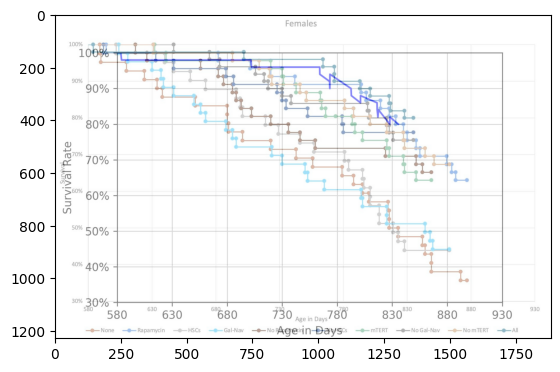

In [7]:
sanity_check_female = cv2.imread('../dat/img/2401_sanity_check.jpg')
plt.figure()

# Display the first image
plt.imshow(raw_plot_image_female)

# Overlay the second image with 50% opacity
plt.imshow(sanity_check_female, alpha=0.5)

In [8]:
def initializeDataFrame(path, sex, category):
    df = loadCSV(path)
    df = roundNumbers(df)
    addColumn(df, 'sex', sex)
    addColumn(df, 'category', category)
    return df

def addTableToDataFrame(df, path, sex, category):
    tabledf = loadCSV(path)
    tabledf = roundNumbers(tabledf)
    addColumn(tabledf, 'sex', sex)
    addColumn(tabledf, 'category', category)
    df = pd.concat([df, tabledf], ignore_index=True)
    return df

def addColumn(data_frame, col_name, col_value):
    data_frame[col_name] = col_value

# Add the columns for the first group
addColumn(female_df, 'sex', 'female')
addColumn(female_df, 'category', 'All')

# Add the other groups to this data frame
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_Gal-Nav.csv', 'female', 'Gal-Nav')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_HSCs.csv', 'female', 'HSCs')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_mTERT.csv', 'female', 'mTERT')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_Gal-Nav.csv', 'female', 'no_Gal_Nav')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_HSCs.csv', 'female', 'no_HSCs')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_mTERT.csv', 'female', 'no_mTERT')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_Rapamycin.csv', 'female', 'no_Rapamycin')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_None.csv', 'female', 'None')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_Rapamycin.csv', 'female', 'Rapamycin')

female_df

,x,y,sex,category
0,580.00,1.00,female,All
1,583.37,1.00,female,All
2,583.99,0.98,female,All
3,701.65,0.98,female,All
4,702.15,0.96,female,All
...,...,...,...,...
354,864.76,0.65,female,Rapamycin
355,865.46,0.68,female,Rapamycin
356,868.12,0.63,female,Rapamycin
357,868.34,0.65,female,Rapamycin


We do the same for the male data set.

In [9]:
male_df = initializeDataFrame('../dat/RMR_data/male_All.csv', 'male', 'All')
male_df['y'] = male_df['y'] / 100

# Add the other groups to this data frame
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_Gal-Nav.csv', 'male', 'Gal-Nav')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_HSCs.csv', 'male', 'HSCs')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_mTERT.csv', 'male', 'mTERT')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_Gal-Nav.csv', 'male', 'no_Gal_Nav')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_HSCs.csv', 'male', 'no_HSCs')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_mTERT.csv', 'male', 'no_mTERT')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_Rapamycin.csv', 'male', 'no_Rapamycin')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_None.csv', 'male', 'None')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_Rapamycin.csv', 'male', 'Rapamycin')

male_df

,x,y,sex,category
0,580.00,0.0100,male,All
1,673.09,0.0100,male,All
2,673.20,0.0098,male,All
3,679.70,0.0096,male,All
4,679.84,0.0098,male,All
...,...,...,...,...
280,845.89,0.7700,male,Rapamycin
281,846.23,0.7500,male,Rapamycin
282,869.76,0.7300,male,Rapamycin
283,869.94,0.7500,male,Rapamycin


Finally we save the data frames as csv files to use them for our further data analyis.

In [10]:
female_df.to_csv('../dat/RMR_data/female_final.csv', index=False)
male_df.to_csv('../dat/RMR_data/male_final.csv', index=False)